Nama : Arif Muhammad Laduni

NIM : 1103213003

Lecture : 6

Metode : Spectral clustering

# 2.3.5. Spectral clustering

### Spectral clustering for image segmentation

**Generate the data**

In [ ]:
import numpy as np

l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1**2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2**2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3**2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4**2

**Plotting four circles**

In [ ]:
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

Convert the image into a graph with the value of the gradient on the edges.

In [ ]:
from sklearn.feature_extraction import image

graph = image.img_to_graph(img, mask=mask)

Take a decreasing function of the gradient resulting in a segmentation that is close to a Voronoi partition

In [ ]:
graph.data = np.exp(-graph.data / graph.data.std())

Here we perform spectral clustering using the arpack solver since amg is numerically unstable on this example. We then plot the results.

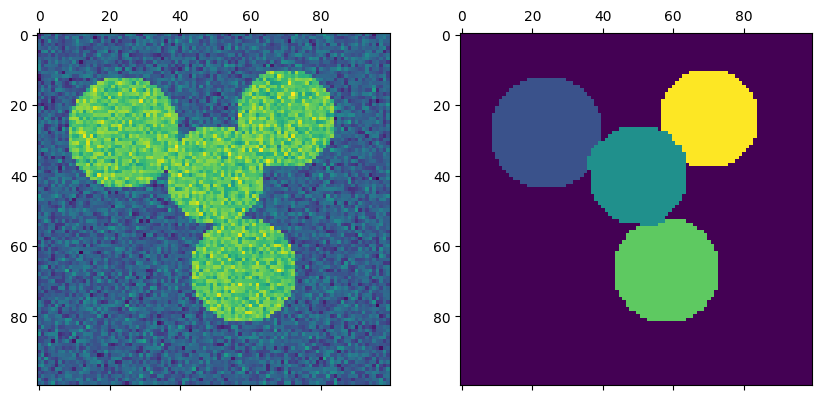

In [ ]:
import matplotlib.pyplot as plt

from sklearn.cluster import spectral_clustering

labels = spectral_clustering(graph, n_clusters=4, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(label_im)

plt.show()

**Plotting two circles**

Here we repeat the above process but only consider the first two circles we generated. Note that this results in a cleaner separation between the circles as the region sizes are easier to balance in this case

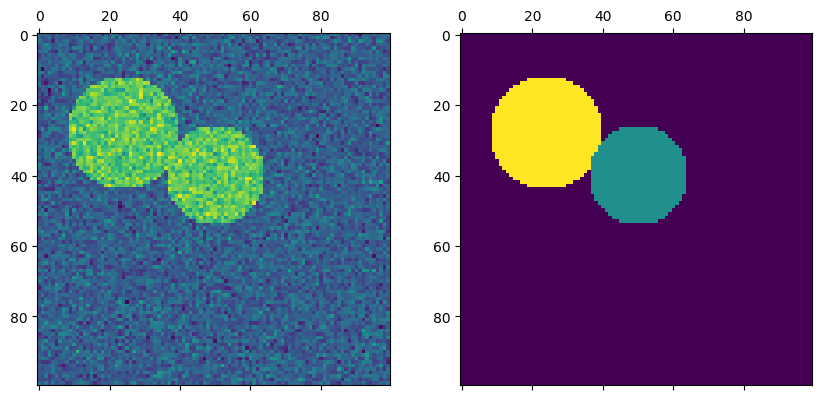

In [ ]:
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2 * np.random.randn(*img.shape)

graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters=2, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(label_im)

plt.show()

### Segmenting the picture of greek coins in regions

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.data import coins
from skimage.transform import rescale

from sklearn.cluster import spectral_clustering
from sklearn.feature_extraction import image

# load the coins as a numpy array
orig_coins = coins()

# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(smoothened_coins, 0.2, mode="reflect", anti_aliasing=False)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(rescaled_coins)

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 10
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

# The number of segmented regions to display needs to be chosen manually.
# The current version of 'spectral_clustering' does not support determining
# the number of good quality clusters automatically.
n_regions = 26

Compute and visualize the resulting regions

Spectral clustering: kmeans, 10.16s
Spectral clustering: discretize, 8.45s
Spectral clustering: cluster_qr, 5.14s


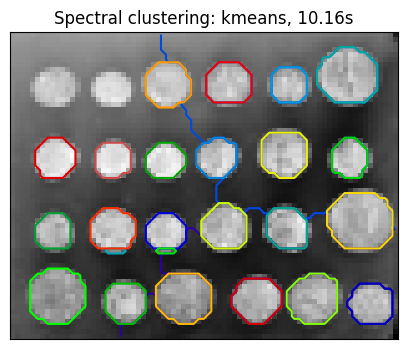

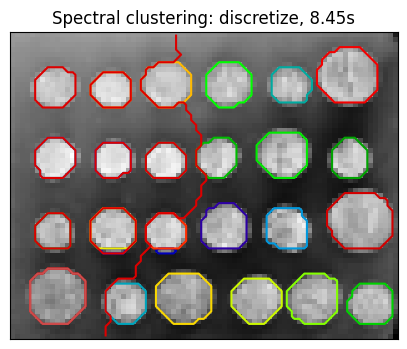

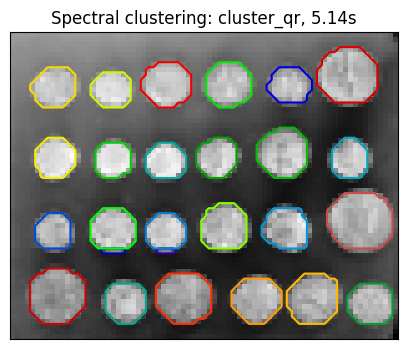

In [ ]:
# Computing a few extra eigenvectors may speed up the eigen_solver.
# The spectral clustering quality may also benefit from requesting
# extra regions for segmentation.
n_regions_plus = 3

# Apply spectral clustering using the default eigen_solver='arpack'.
# Any implemented solver can be used: eigen_solver='arpack', 'lobpcg', or 'amg'.
# Choosing eigen_solver='amg' requires an extra package called 'pyamg'.
# The quality of segmentation and the speed of calculations is mostly determined
# by the choice of the solver and the value of the tolerance 'eigen_tol'.
# TODO: varying eigen_tol seems to have no effect for 'lobpcg' and 'amg' #21243.
for assign_labels in ("kmeans", "discretize", "cluster_qr"):
    t0 = time.time()
    labels = spectral_clustering(
        graph,
        n_clusters=(n_regions + n_regions_plus),
        eigen_tol=1e-7,
        assign_labels=assign_labels,
        random_state=42,
    )

    t1 = time.time()
    labels = labels.reshape(rescaled_coins.shape)
    plt.figure(figsize=(5, 5))
    plt.imshow(rescaled_coins, cmap=plt.cm.gray)

    plt.xticks(())
    plt.yticks(())
    title = "Spectral clustering: %s, %.2fs" % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
    for l in range(n_regions):
        colors = [plt.cm.nipy_spectral((l + 4) / float(n_regions + 4))]
        plt.contour(labels == l, colors=colors)
        # To view individual segments as appear comment in plt.pause(0.5)
plt.show()

# TODO: After #21194 is merged and #21243 is fixed, check which eigen_solver
# is the best and set eigen_solver='arpack', 'lobpcg', or 'amg' and eigen_tol
# explicitly in this example.